<center><h1>Final Project: Steam Games Recommender System</h1></center>

<center><b><h3>Team C: Thomas Katraouras, Vasileios Giosis, Konstantinos Kokkalis</h3></b></center>


<br>
<br>
<br>

Our recommender system recommends Steam games to a user in 3 different ways:<br><br>
1. It takes the user's top X favorite games according to playtime (our users dataset does not have rating data, only playtime), and recommends Y similar games according to the similarity of various tags (like genre, multiplayer or not, etc).<br>
2. It takes the user's top X favorite games according to playtime and recommends Y games from the publisher of each game.<br>
3. It recommends X games based on what other users are playing the most.<br><br>

Methods 1 and 2 also put a weight on higher overall rated games, to prevent the users from getting recommended bad games, even if they are similar.

<br>
<b>There is an interactive GUI in the end of this notebook which demonstrates the full functionality of our recommender. You can try it, but make sure to run the whole notebook first.</b><br>

<b>Below the GUI is a simple attempt we made to create the recommender system using Neural Networks, which was asked after we had planned and made the system we decribe in this notebook</b>

<br>

We utilized two datasets.<br><br> 
The [steam_200k](https://www.kaggle.com/datasets/tamber/steam-video-games) dataset, which has data from around 200k users. More specifically, it has data about the games owned by them and the play time on each game. We got it from Kaggle.<br><br>
The [steam_games](https://www.kaggle.com/datasets/nikdavis/steam-store-games?select=steam.csv) dataset, which has data for a plethora of games on the platform. The dataset was pulled from Kaggle and is already clean (no duplicate or empty entries), which is very convenient for us. More specifically, it has data about the game's name, developer, publisher, various tags, genre info and steamspy tags (steamspy is a popular website for steam games categorisation and research). It also has data about positive and negative reviews, and more.<br>

<br>

# STEAM USERS DATASET

### Dataset Preprocessing

We start by processing the steam_200k dataset, which will be used for collaborative filtering, more specifically for method 3 (recommend a game based on what other users are playing), but will also be used to pick games for methods 1 and 2.

The dataset was a bit weird, it had no column names by default so we had to add our own. By default, the first row had become column names so we handled this as well. Finally, there was a useless column filled all with zeros, which we removed.

In [81]:
import numpy as np
import pandas as pd

data_users = pd.read_csv('./steam_200k.csv')

# Save the current column names (data in the first row)
current_column_names = data_users.columns.tolist()

# Define the new column names
new_column_names = ['user_id', 'game', 'behavior', 'playtime', 'zero']

# Assign new column names
data_users.columns = new_column_names

# Append the data from current_column_names as a new row at the beginning of the DataFrame
data_users.loc[-1] = current_column_names
data_users = data_users.reset_index(drop=True)

# Drop this useless column
data_users = data_users.drop('zero', axis = 1)

In [82]:
data_users.head()

,user_id,game,behavior,playtime
0,151603712,The Elder Scrolls V Skyrim,play,273.0
1,151603712,Fallout 4,purchase,1.0
2,151603712,Fallout 4,play,87.0
3,151603712,Spore,purchase,1.0
4,151603712,Spore,play,14.9


We proceed by creating steam_data_purchase, which only holds info about purchased games for each user (not played / play time). We then create steam_data_purchase_gr, which groups by user_id, to have all purchased games for each user. Will be used later in the implementation.

In [83]:
steam_data_purchase = data_users.loc[data_users.behavior=='purchase']
steam_data_purchase_gr = steam_data_purchase.groupby('user_id')

Now remove all 'purchase' behaviors and keep only play time in our data (we have kept the list of purchases above so we do not need it in the main df anymore).

In [84]:
data_users = data_users[data_users['behavior'] == 'play'].copy()

data_users.head()

,user_id,game,behavior,playtime
0,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,play,87.0
4,151603712,Spore,play,14.9
6,151603712,Fallout New Vegas,play,12.1
8,151603712,Left 4 Dead 2,play,8.9


Since we do not know if this dataset is clean, we need to do some processing.

First of all, we check if there is missing data.

In [85]:
data_users.isnull().all()

user_id     False
game        False
behavior    False
playtime    False
dtype: bool

There is no missing data. Let's check for outliers.

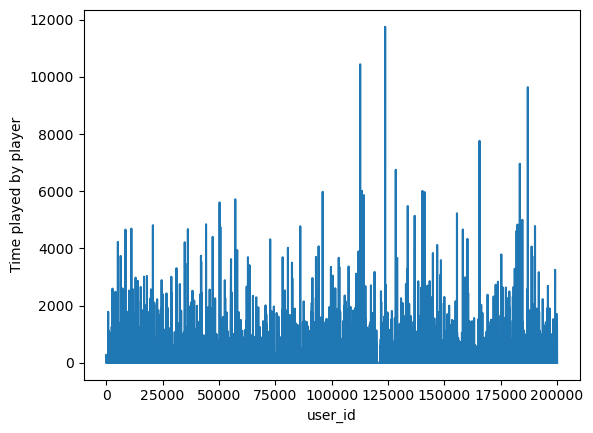

In [86]:
import matplotlib.pyplot as plt

plt.plot(data_users['playtime'])
plt.xlabel('user_id')
plt.ylabel('Time played by player')
plt.show()

As we can see, some players have an insane amount of hours played on some games. We would like to remove these outliers for smoother data. We will create another df for the clean and normalized values, since we want to keep all the original data intact for each user, to later find their favorite / most played games.

In [87]:
# Remove outliers
from scipy.stats import iqr

iqr = iqr(data_users['playtime'])
q1 = np.percentile(data_users['playtime'], 25)
q3 = np.percentile(data_users['playtime'], 75)

# Using the most common threshold
threshold = 1.5
lower_bound = q1 - threshold * iqr
upper_bound = q3 + threshold * iqr

outliers = (data_users['playtime'] < lower_bound) | (data_users['playtime'] > upper_bound)

data_users_norm = data_users[~outliers].copy()

Let's check again.

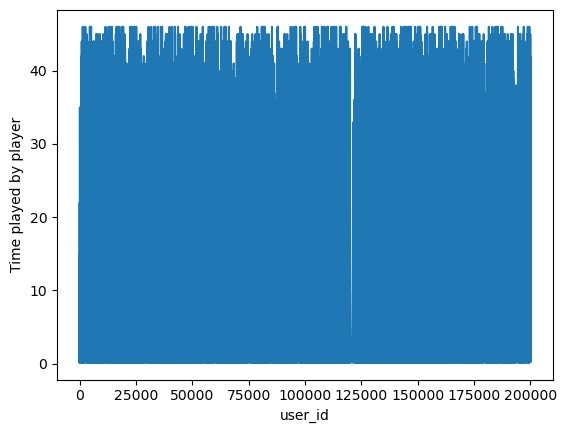

In [88]:
plt.plot(data_users_norm['playtime'])
plt.xlabel('user_id')
plt.ylabel('Time played by player')
plt.show()

Our data is now free of outliers. Next, we want to normalize our data before applying SVD.

In [89]:
# Normalization
from sklearn.preprocessing import MinMaxScaler

playtime_column = data_users_norm['playtime'].values.reshape(-1, 1)  # Reshape to a 2D array

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
normalized_playtime = scaler.fit_transform(playtime_column)

# Update the 'playtime' column in the original DataFrame with the normalized values
data_users_norm['playtime'] = normalized_playtime.flatten()

data_users_norm.head()

,user_id,game,behavior,playtime
4,151603712,Spore,play,0.322440
6,151603712,Fallout New Vegas,play,0.261438
8,151603712,Left 4 Dead 2,play,0.191721
10,151603712,HuniePop,play,0.183007
12,151603712,Path of Exile,play,0.174292


## Recommend games based on what other users have played the most

In this case, we chose to create a user-item matrix and use Singular Value Decomposition (SVD) for Matrix Factorization, in order to give recommendations. SVD helps discover user-item interactions and recommend most relevant games.

We decided not to split into training and testing datasets, since we are applying SVD directly to our data for matrix factorization, without training a model on it. In other words, SVD is not part of a broader machine learning model in our case, which requires evaluation.

We create a playtime matrix, which is a user-item matrix, holding numerical values. For every user and every game, how many hours the user has played, NaN if they haven't played.

In [90]:
# The matrix is obviously empty in the beginning

playtime_matrix = pd.DataFrame(index=data_users_norm['user_id'].unique(), columns=data_users_norm['game'].unique())
playtime_matrix.head()

,Spore,Fallout New Vegas,Left 4 Dead 2,HuniePop,Path of Exile,Poly Bridge,Left 4 Dead,Team Fortress 2,Tomb Raider,The Banner Saga,...,Adventure Time Explore the Dungeon Because I DONT KNOW!,Ride! Carnival Tycoon,SAMURAI WARRIORS 4-II,The Bug Butcher,Romance of the Three Kingdoms Maker,Space Colony,Life is Hard,Executive Assault,O.R.B.,MirrorMoon EP
151603712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187131847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59945701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53875128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140954425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
# Fill with data

for i in range(len(data_users_norm)):
    user = data_users_norm.iloc[i]['user_id']
    game = data_users_norm.iloc[i]['game']
    playtime_matrix.loc[user,game] = data_users_norm.iloc[i]['playtime']
    
playtime_matrix.head()

,Spore,Fallout New Vegas,Left 4 Dead 2,HuniePop,Path of Exile,Poly Bridge,Left 4 Dead,Team Fortress 2,Tomb Raider,The Banner Saga,...,Adventure Time Explore the Dungeon Because I DONT KNOW!,Ride! Carnival Tycoon,SAMURAI WARRIORS 4-II,The Bug Butcher,Romance of the Three Kingdoms Maker,Space Colony,Life is Hard,Executive Assault,O.R.B.,MirrorMoon EP
151603712,0.32244,0.261438,0.191721,0.183007,0.174292,0.16122,0.069717,0.058824,0.052288,0.041394,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187131847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59945701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53875128,0.008715,0.16122,NaN,NaN,NaN,NaN,0.034858,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140954425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.281046,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Obviously, there are many NaN entries, which means the user does not own the game or owns it but has never played (rare case). In this scenario, we fill the NaN cells with 0, which is the most rational, since the user has practically played 0 hours.

In [92]:
# Replace NaN values with 0

playtime_matrix.fillna(0, inplace=True)
playtime_matrix.head()

,Spore,Fallout New Vegas,Left 4 Dead 2,HuniePop,Path of Exile,Poly Bridge,Left 4 Dead,Team Fortress 2,Tomb Raider,The Banner Saga,...,Adventure Time Explore the Dungeon Because I DONT KNOW!,Ride! Carnival Tycoon,SAMURAI WARRIORS 4-II,The Bug Butcher,Romance of the Three Kingdoms Maker,Space Colony,Life is Hard,Executive Assault,O.R.B.,MirrorMoon EP
151603712,0.322440,0.261438,0.191721,0.183007,0.174292,0.16122,0.069717,0.058824,0.052288,0.041394,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187131847,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59945701,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53875128,0.008715,0.161220,0.000000,0.000000,0.000000,0.00000,0.034858,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140954425,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.281046,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Apply SVD on the playtime matrix.

In [93]:
from scipy.sparse.linalg import svds

playtime_matrix_filled = playtime_matrix.to_numpy()

# Apply SVD
U_svd, sigma_svd, Vt_svd = svds(playtime_matrix_filled.astype(float), k=2)

# Construct diagonal array in SVD
sigma_svd = np.diag(sigma_svd)

# Reconstruct the matrix
approximated_playtime = np.dot(np.dot(U_svd, sigma_svd), Vt_svd)

# Convert back to DataFrame for easier interpretation
approximated_playtime_df = pd.DataFrame(approximated_playtime, columns=playtime_matrix.columns, index=playtime_matrix.index)
approximated_playtime_df.head()

,Spore,Fallout New Vegas,Left 4 Dead 2,HuniePop,Path of Exile,Poly Bridge,Left 4 Dead,Team Fortress 2,Tomb Raider,The Banner Saga,...,Adventure Time Explore the Dungeon Because I DONT KNOW!,Ride! Carnival Tycoon,SAMURAI WARRIORS 4-II,The Bug Butcher,Romance of the Three Kingdoms Maker,Space Colony,Life is Hard,Executive Assault,O.R.B.,MirrorMoon EP
151603712,0.001735,0.012915,0.035655,0.001195,0.004688,0.000116,0.008286,0.048516,0.012772,0.001796,...,2.439705e-07,-3.487759e-19,0.000013,1.231629e-06,4.069447e-07,0.000097,0.000024,0.000021,4.868223e-06,4.056852e-06
187131847,0.000016,-0.000142,0.000125,0.000044,0.000564,0.000004,-0.000075,0.000741,-0.000215,-0.000058,...,-3.934782e-09,2.248890e-20,0.000007,6.367542e-07,-1.378308e-08,-0.000005,-0.000001,-0.000001,-2.770545e-07,-2.308787e-07
59945701,0.001690,0.012632,0.034763,0.001156,0.004454,0.000112,0.008101,0.047181,0.012509,0.001765,...,2.388940e-07,-3.451217e-19,0.000011,1.065714e-06,4.000197e-07,0.000095,0.000024,0.000021,4.809345e-06,4.007787e-06
53875128,0.012330,0.092380,0.253853,0.008415,0.032115,0.000816,0.059235,0.344107,0.091536,0.012935,...,1.748053e-06,-2.537838e-18,0.000077,7.311875e-06,2.932400e-06,0.000701,0.000177,0.000153,3.533832e-05,2.944860e-05
140954425,0.001396,0.010419,0.028714,0.000958,0.003722,0.000093,0.006683,0.039016,0.010311,0.001453,...,1.969464e-07,-2.831984e-19,0.000010,9.301009e-07,3.292135e-07,0.000078,0.000020,0.000017,3.949291e-06,3.291076e-06


The function below recommends num_recommendations games, for user user_id, based on the predictions made above. Therefore, these recommendations are purely based on what other users have played (and not the game type in this case).

In [94]:
def recommend_games_based_on_other_users(user_id, num_recommendations, predictions, user_id_groups):
    # Get and sort the user's predictions
    sorted_user_predictions = predictions.loc[user_id].sort_values(ascending=False)
    
    # Get list of purchased games
    purchased_games = user_id_groups.get_group(user_id)['game'].unique().tolist()
    
    # Recommend the highest predicted rating games that the user hasn't played yet.
    count_games = 0 
    recommendations = []
    for i in range(0,sorted_user_predictions.shape[0],1):
        predicted_game_score = sorted_user_predictions[i]
        predicted_game_name = sorted_user_predictions.index[i]
        if predicted_game_name not in purchased_games:
            count_games+=1
            recommendations.append(predicted_game_name)
        if count_games >= num_recommendations:
            break

    return recommendations

Let's try it for user 236188947. First check what they have purchased, then recommend 5 games for them.

In [95]:
steam_data_purchase_gr.get_group(236188947)['game'].unique().tolist()

['Grand Theft Auto V',
 'Soccer Manager 2015',
 'METAL SLUG DEFENSE',
 'Dirty Bomb']

In [96]:
target_user = 236188947

recommendations = recommend_games_based_on_other_users(target_user, 5, approximated_playtime_df, steam_data_purchase_gr)

print(f"Top 5 Recommendations for user '{target_user}' based on what other users play:")
for i, game in enumerate(recommendations):
    print(f"{i + 1}. {game}")

Top 5 Recommendations for user '236188947' based on what other users play:
1. Team Fortress 2
2. Left 4 Dead 2
3. Portal 2
4. Counter-Strike Global Offensive
5. Garry's Mod


<br>

# STEAM GAMES DATASET

### Dataset Preprocessing

Now, we process the steam_games dataset, which will be used for methods 1 and 2 (recommend a game based on tags or based on publisher, weighted by the overall reviews).

In [97]:
import numpy as np
import pandas as pd

data = pd.read_csv('./steam_games.csv')

In [98]:
data.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


Drop the columns we do not need for our implementation.

In [99]:
data = data.drop('owners', axis = 1)
data = data.drop('release_date', axis = 1)
data = data.drop('english', axis = 1)
data = data.drop('platforms', axis = 1)
data = data.drop('required_age', axis = 1)
data = data.drop('achievements', axis = 1)

# SteamSpy tags are more than enough, only keep those
# and remove categories and genres columns
data = data.drop('categories', axis = 1)
data = data.drop('genres', axis = 1)

data = data.drop('appid', axis = 1)
data = data.drop('developer', axis = 1)
data = data.drop('average_playtime', axis = 1)
data = data.drop('median_playtime', axis = 1)
data = data.drop('price', axis = 1)

In [100]:
data.head()

,name,publisher,steamspy_tags,positive_ratings,negative_ratings
0,Counter-Strike,Valve,Action;FPS;Multiplayer,124534,3339
1,Team Fortress Classic,Valve,Action;FPS;Multiplayer,3318,633
2,Day of Defeat,Valve,FPS;World War II;Multiplayer,3416,398
3,Deathmatch Classic,Valve,Action;FPS;Multiplayer,1273,267
4,Half-Life: Opposing Force,Valve,FPS;Action;Sci-fi,5250,288


For the tags text feature, we chose to go with TF-IDF Vectorization, which is suitable when we have natural language content, like descriptions or - in our case - tags. We start by tokenizing the column, since the tags are seperated by ; . We then convert them to a text format and store them in a temporary column, to apply TF-IDF Vectorization, which will generate our tags_tfidf_matrix.

In [101]:
# Tokenize steamspy_tags

data['steamspy_tags'] = data['steamspy_tags'].apply(lambda tags: tags.split(';'))
data.head()

,name,publisher,steamspy_tags,positive_ratings,negative_ratings
0,Counter-Strike,Valve,"[Action, FPS, Multiplayer]",124534,3339
1,Team Fortress Classic,Valve,"[Action, FPS, Multiplayer]",3318,633
2,Day of Defeat,Valve,"[FPS, World War II, Multiplayer]",3416,398
3,Deathmatch Classic,Valve,"[Action, FPS, Multiplayer]",1273,267
4,Half-Life: Opposing Force,Valve,"[FPS, Action, Sci-fi]",5250,288


In [102]:
# Convert the tags into a text format
data['tags_text'] = data['steamspy_tags'].apply(lambda tags: ' '.join(tags))

data.head()

,name,publisher,steamspy_tags,positive_ratings,negative_ratings,tags_text
0,Counter-Strike,Valve,"[Action, FPS, Multiplayer]",124534,3339,Action FPS Multiplayer
1,Team Fortress Classic,Valve,"[Action, FPS, Multiplayer]",3318,633,Action FPS Multiplayer
2,Day of Defeat,Valve,"[FPS, World War II, Multiplayer]",3416,398,FPS World War II Multiplayer
3,Deathmatch Classic,Valve,"[Action, FPS, Multiplayer]",1273,267,Action FPS Multiplayer
4,Half-Life: Opposing Force,Valve,"[FPS, Action, Sci-fi]",5250,288,FPS Action Sci-fi


In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
tags_tfidf_matrix = tfidf_vectorizer.fit_transform(data['tags_text'])

Remove the temporary text column and the tags column, since we have generated our tags_tfidf_matrix

In [104]:
data = data.drop('tags_text', axis = 1)
data = data.drop('steamspy_tags', axis = 1)

Set the row indexes as the game name, easier to find data for each game in our implementation. The reason we do not remove the publisher column, although we apply TF-IDF to it too below, is because we need this info later when trying to find the publisher name for each game.

In [105]:
data.set_index('name', inplace=True)
data.head()

,publisher,positive_ratings,negative_ratings
name,,,
Counter-Strike,Valve,124534,3339
Team Fortress Classic,Valve,3318,633
Day of Defeat,Valve,3416,398
Deathmatch Classic,Valve,1273,267
Half-Life: Opposing Force,Valve,5250,288


For example, to get info about Grand Theft Auto V

In [106]:
data.loc['Grand Theft Auto V']

publisher           Rockstar Games
positive_ratings            329061
negative_ratings            139308
Name: Grand Theft Auto V, dtype: object

We did not check for missing / duplicate values since we know the dataset is clean. We do not have any numerical data to check for outliers or normalize (positive / negative ratings are numerical but are used as a weight, per game so there is no point in normalizing). Also, in cosine similarity, data normalization is generally not required.

## Recommend games based on similarity

For this part of the recommender system, we chose to go with cosine similarity. This is because this part does item-based filtering (will be used for our content-based filtering later too, where it chooses games based on the games the user has played the most). Therefore, cosine similarity is a good way to figure out which games have similar features (aka tags in this case).

Once again, we do not split training and testing sets, as cosine similarity itself is a similarity measure and not a model that requires training. This part is mainly item-based and content-based, which relies on the features of items and does not involve explicit training phases.

Furthermore, we calculate the ratio of positive to negative reviews. If the game's reviews are bad according to the threshold specified (we chose 1.5, which means we consider a game to have bad rating if more than 40% of reviews are negative), the game is downweighted by a weight factor. Therefore the user will get higher rated games of close similarity first.

In [107]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

cosine_sim_tags = linear_kernel(tags_tfidf_matrix, tags_tfidf_matrix)

# Calculate positive-to-negative ratings ratio
positive_ratings = data['positive_ratings'].values
negative_ratings = data['negative_ratings'].values
ratio_threshold = 1.5  # Adjust the threshold as needed

# Avoid division by zero by adding a small constant
ratio = np.divide(positive_ratings, negative_ratings + 1e-5)

# Weight factor for ratings based on the ratio
ratings_weight = 0.7

# Apply a mask to downweight games with a low positive-to-negative ratings ratio
mask = ratio < ratio_threshold
downweighted_cosine_sim = cosine_sim_tags.copy()
downweighted_cosine_sim[:, mask] *= (1 - ratings_weight)

The function below returns n game recommendations, and always checks that the target game is not in the list, and also makes sure to not recommend games the user already owns. However, since we can just provide a game name to get recommendations without having any user, we can set user_id < 0 to ignore the user purchase list checks. We also set a try except statement, in case the game does not exist in the dataset.

In [108]:
# Function to get top N recommendations for a given game
def get_top_n_recommendations(game_name, cosine_sim_matrix, user_id_groups, user_id, n=5):
    try:
        game_index = data.index.get_loc(game_name)
    except:
        return []
    similarities = cosine_sim_matrix[game_index]
    similar_games_indices = similarities.argsort()[::-1][1:]
    
    # Get list of purchased games
    purchased_games = []
    if(user_id >= 0):
        purchased_games = user_id_groups.get_group(user_id)['game'].unique().astype(str).tolist()

    # Filter out the target game from the recommendations
    target_game_index = data.index.get_loc(game_name)
    similar_games_indices = [idx for idx in similar_games_indices if idx != target_game_index]

    # Ensure that at least N recommendations are returned
    recommendations = []
    for idx in similar_games_indices:
        if len(recommendations) >= n:
            break
        recommended_game = data.index[idx]
        # Check if the recommended game is not already purchased
        if recommended_game not in purchased_games:
            recommendations.append(recommended_game)

    return recommendations

Now let's try it. We will run it below for the game Dota 2. Then we will run it for the same game but we will generate the cosine_sim_tags without weighting it based on reviews.

In [109]:
target_game = 'Dota 2'
recommendations = get_top_n_recommendations(target_game, downweighted_cosine_sim, steam_data_purchase_gr, -1, n=5)

# Print the recommendations
print(f"Top 5 Recommendations for '{target_game}':")

# Handle game not found case
if(recommendations == []):
    print("Sorry, we cannot get any recommendations for this game.")
    
for i, game in enumerate(recommendations):
    print(f"{i + 1}. {game}")

Top 5 Recommendations for 'Dota 2':
1. Bloodline Champions
2. Strife®
3. SMITE®
4. Iron League
5. Vainglory


In [110]:
# Example without weight based on positive / negative ratings
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

cosine_sim_tags_no_weight = linear_kernel(tags_tfidf_matrix, tags_tfidf_matrix)

target_game = 'Dota 2'
recommendations = get_top_n_recommendations(target_game, cosine_sim_tags_no_weight, steam_data_purchase_gr, -1, n=5)

# Print the recommendations
print(f"Top 5 Recommendations for '{target_game}':")

# Handle game not found case
if(recommendations == []):
    print("Sorry, we cannot get any recommendations for this game.")
    
for i, game in enumerate(recommendations):
    print(f"{i + 1}. {game}")

Top 5 Recommendations for 'Dota 2':
1. Games of Glory
2. Heroes of SoulCraft - Arcade MOBA
3. Bloodline Champions
4. Strife®
5. SMITE®


What do we notice? In the no-weight recommendation, the user got recommended the game 'Games of Glory'. Looking it up on Steam, it indeed matches similarity to 'Dota 2' (it is free to play, MOBA, etc), but the reviews are bad. Over 45% of the reviews are negative. Same goes with 'Heroes of SoulCraft - Arcade MOBA'. It matches in similarity but 60% of its reviews are negative.<br><br>
As we can see, our weighted implementation recommended 'Bloodline Champions' as number one, which is a MOBA game with very high positive ratings (over 85%). It also brought 'Strife®' and 'SMITE®' higher on the list, both of which are well-respected games in the Steam community. Finally, it recommended two more similar games with good ratings.<br><br>
Therefore, we can verify our weighted-by-reviews implementation does what it is supposed to do.<br>

### Recommend games from the same publisher

Another common practice on the Steam platform, is recommending games of the same publishers / developers as the games the user already owns. We chose to do it just for publishers, but it is exactly the same for developers.

Like with tags previously, we will use TF-IDF Vectorization for publishers.

In [111]:
# TF-IDF Vectorization of publishers

tfidf_vectorizer_pub = TfidfVectorizer()
pub_tfidf_matrix = tfidf_vectorizer_pub.fit_transform(data['publisher'].astype(str))

Also, we will use weighted cosine similarity again.

In [112]:
# Calculate cosine similarity between games based on publishers
cosine_sim_pub = linear_kernel(pub_tfidf_matrix, pub_tfidf_matrix)

# Apply the positive-to-negative reviews ratio weighting method like above
positive_ratings = data['positive_ratings'].values
negative_ratings = data['negative_ratings'].values
ratio = np.divide(positive_ratings, negative_ratings + 1e-5)
ratio_threshold = 1.2  # Adjust the threshold as needed

# Weight factor for ratings based on the ratio
ratings_weight = 0.7

# Apply a mask to downweight games with a low positive-to-negative ratings ratio
mask = ratio < ratio_threshold
downweighted_cosine_sim_pub = cosine_sim_pub.copy()
downweighted_cosine_sim_pub[:, mask] *= (1 - ratings_weight)

Let's try for the game 'Tom Clancy's Rainbow Six® Siege' with our implementation, and without the weight.

In [113]:
target_game = 'Tom Clancy\'s Rainbow Six® Siege'
publisher_recommendations = get_top_n_recommendations(target_game, downweighted_cosine_sim_pub, steam_data_purchase_gr, -1, n=5)

# Print the recommendations
print(f"Top 5 Recommendations for '{target_game}' based on Publisher:")

# Handle game not found case
if(recommendations == []):
    print("Sorry, we cannot get any recommendations for this game.")
    
for i, game in enumerate(publisher_recommendations):
    print(f"{i + 1}. {game}")

Top 5 Recommendations for 'Tom Clancy's Rainbow Six® Siege' based on Publisher:
1. Beyond Good and Evil™
2. Assassin's Creed® Odyssey
3. Brothers in Arms: Earned in Blood™
4. Tom Clancy's Rainbow Six® Vegas 2
5. Far Cry® 2: Fortune's Edition


In [114]:
# Calculate cosine similarity between games based on publishers without weight
cosine_sim_pub_no_weight = linear_kernel(pub_tfidf_matrix, pub_tfidf_matrix)

target_game = 'Tom Clancy\'s Rainbow Six® Siege'
publisher_recommendations = get_top_n_recommendations(target_game, cosine_sim_pub_no_weight, steam_data_purchase_gr, -1, n=5)

# Print the recommendations
print(f"Top 5 Recommendations for '{target_game}' based on Publisher:")

# Handle game not found case
if(recommendations == []):
    print("Sorry, we cannot get any recommendations for this game.")
    
for i, game in enumerate(publisher_recommendations):
    print(f"{i + 1}. {game}")

Top 5 Recommendations for 'Tom Clancy's Rainbow Six® Siege' based on Publisher:
1. Trials® Rising
2. Assassin's Creed™: Director's Cut Edition
3. Assassin's Creed® Odyssey
4. Brothers in Arms: Earned in Blood™
5. Tom Clancy's Rainbow Six® Vegas 2


As we can notice, the recommender system recommends games from the same publisher (in this case Ubisoft), but there are some differences because of ratings. The most important one here is that the non-weighted system recommends 'Trials® Rising', which is a Ubisoft game, but with mediocre rating. Our weighted system does not even recommend it, and puts 'Beyond Good and Evil™' in its place, which is exceptional according to users' ratings.

<br>

# User-Specific Recommendations

Now let's combine the two datasets for collaborative filtering. We will ask for the User ID, then find out the user's top games by play time and recommend games using methods 2 and 3 (similarity and publisher). We will also recommend games using method 1 (based on what other users are playing).

In [115]:
# This function returns the top X favorite games for a given user based on playtime.
def user_favorite_games(user_id, X):
    user_data = data_users[data_users['user_id'] == user_id]  # Filter data for the specified user
    user_data_sorted = user_data.sort_values(by='playtime', ascending=False)  # Sort by playtime
    fav_games = user_data_sorted.head(X)  # Select the favorite X games
    fav_games_list = fav_games[['game', 'playtime']].values.tolist()
    
    return fav_games_list

In [116]:
print(user_favorite_games(99096740, 5))

[['Dota 2', 1704.0], ['Warframe', 186.0], ['Far Cry 3', 80.0], ['Grand Theft Auto V', 68.0], ['DayZ', 59.0]]


The function below recommends games to user based on their favorite games X is the number of game to recommend for each category (similarity, publisher, other users) Y is the number of the user's top games to base the recommendation on. For example for X = 5 and Y = 2, we will find their top 2 games and recommend 5 games based on similarity, 5 games based on publisher and 5 games based on other users, for each of their 2 favorite games.

We check if the user ID exists, if it does not, an error is printed and the function does not proceed.

In [117]:
def recommend_games(user_id, X, Y):
    if(user_id not in data_users['user_id'].values):
        print("User does not exist.")
        return

    fav_games = user_favorite_games(user_id, Y)
    
    print(f"~~~~~~~~~~~RECOMMENDATIONS FOR USER {user_id}~~~~~~~~~~~\n\n")
    
    # Print the recommendations
    for i, game in enumerate(fav_games):
        print(f"You really like {game[0]}, you have played for {int(game[1])} hours.\n\nGames similar to {game[0]} you might like:")
        
        recommendations = get_top_n_recommendations(game[0], downweighted_cosine_sim, steam_data_purchase_gr, user_id, X)
        
        # Handle the case where the user has a game not in the games dataset
        if(recommendations == []):
            print("Sorry, we cannot get any recommendations for this game.")
            print("\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n\n")
            continue
        for j, gamerec in enumerate(recommendations):
            print(f"{j + 1}. {gamerec}")
            
        print(f"\nOther games from the publisher of {game[0]}, {data.loc[game[0]]['publisher']}:")
        publisher_recommendations = get_top_n_recommendations(game[0], downweighted_cosine_sim_pub, steam_data_purchase_gr, user_id, X)
        for j, gamerec in enumerate(publisher_recommendations):
            print(f"{j + 1}. {gamerec}")
        
        print("\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n\n")
    
    print("\nFinally, here are some recommendations based on what other users are playing:")
    users_recommendations = recommend_games_based_on_other_users(user_id, X, approximated_playtime_df, steam_data_purchase_gr)
    for j, gamerec in enumerate(users_recommendations):
        print(f"{j + 1}. {gamerec}")

Let's try the final result for user 135400225, X = 5 and Y = 3, and get some recommendations.

In [118]:
recommend_games(135400225, 5, 3)

~~~~~~~~~~~RECOMMENDATIONS FOR USER 135400225~~~~~~~~~~~


You really like Starbound, you have played for 217 hours.

Games similar to Starbound you might like:
1. Xsyon - Prelude
2. Signs of Life
3. Junk Jack
4. SquareWorld Unpixeled
5. Disney Infinity 3.0: Gold Edition

Other games from the publisher of Starbound, Chucklefish:
1. Wargroove
2. Wanderlust Adventures
3. Timespinner
4. Treasure Adventure World
5. Pathway


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


You really like Kerbal Space Program, you have played for 140 hours.

Games similar to Kerbal Space Program you might like:
1. Avorion
2. Universe Sandbox ²
3. StarMade
4. Brick Inventions
5. Stunt Corgi VR

Other games from the publisher of Kerbal Space Program, Private Division :
1. quadrantica
2. Turnover
3. Till the dawn, waiting
4. Fury Strike
5. Rune Lord


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


You really like Terraria, you have played for 105 hours.

Games similar to Terraria you might like:
1

Note: The recommender system would recommend Terraria as similar to Starbound and Starbound as similar to Terraria, since the games are almost the same. However, as we can see, it filtered those recommendations out in both cases since the user owns the games and recommended other games the user has not bought yet.

Let's see how the system handles games not in the steam_games dataset. We know user 131377772 owns some games not in it.

In [119]:
recommend_games(131377772, 5, 3)

~~~~~~~~~~~RECOMMENDATIONS FOR USER 131377772~~~~~~~~~~~


You really like Call of Duty Black Ops II - Multiplayer, you have played for 63 hours.

Games similar to Call of Duty Black Ops II - Multiplayer you might like:
Sorry, we cannot get any recommendations for this game.


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


You really like Call of Duty Black Ops II, you have played for 2 hours.

Games similar to Call of Duty Black Ops II you might like:
Sorry, we cannot get any recommendations for this game.


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


You really like Call of Duty Black Ops II - Zombies, you have played for 1 hours.

Games similar to Call of Duty Black Ops II - Zombies you might like:
Sorry, we cannot get any recommendations for this game.


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



Finally, here are some recommendations based on what other users are playing:
1. Left 4 Dead 2
2. Portal 2
3. Counter-Strike Global Offensive
4. Garry's Mod
5.

<br><br>

# Interactive User-Friendly GUI

As the final step, we decided to implement a simple GUI for the end user using ipywidgets.<br><br>
Specifically, there are 4 inputs. You can either choose to get recommendations based on user ID or game name. <br>
If you choose user ID, you have to input the user ID in the box, then, using the sliders, select the number of games you want recommended for each category (similarity, publisher, other users), and the number of the user's favorite games to take into consideration.<br>
If you choose game name, the user ID field and second slider will be disabled. You can input a game name in the text box and select how many games you want recommended using the first slider. The system will recommend games similar to the one you typed and other good games from its publisher.<br>
Finally, to run the recommender just click the "Run Recommender" Button.

<br>
<br>

In [120]:
import ipywidgets as widgets
from ipywidgets import HBox, Label, Output
from IPython.display import display, clear_output

w1 = HBox([Label('How many games do you want recommended for each category?'),widgets.IntSlider(min=1, max=15)])
w2 = HBox([Label('How many of the user\'s favorite games should be taken into consideration?'),widgets.IntSlider(min=1, max=10)])

w3 = widgets.BoundedIntText(
    min=0,
    max=10000000000,
    step=1,
    description='Type User ID:',
    disabled=False
)

w4 = HBox([Label('Type Game Name:'),widgets.Text(
    disabled=False   
)])

w5 = button = widgets.Button(
    description='Run Recommender',
    disabled=False,
    button_style='',
    tooltip='Run Recommender',
    icon=''
)

w5.on_click(lambda b: callback_function(b, w3.value, w4.children[1].value, w1.children[1].value, w2.children[1].value))

# Create an Output widget for displaying stdout
out = Output()

# Callback function for button
def callback_function(b, user_id, game_name, X, Y):
    # Clear the output container
    out.clear_output(wait=True)
    
    # Call the function with parameters
    with out:
        # Check if user ID has been provided or game name and act accordingly
        # Game name is not empty so user searched by game name
        if(game_name != ""):
            recommendations = get_top_n_recommendations(game_name, downweighted_cosine_sim, steam_data_purchase_gr, -1, X)
        
            # Handle the case where the game provided does not exist in the data
            if(recommendations == []):
                print("Sorry, we cannot get any recommendations for this game.")
                return
            
            print(f"Recommended games, similar to {game_name}:")
            for j, gamerec in enumerate(recommendations):
                print(f"{j + 1}. {gamerec}")

            print(f"\nOther games from the publisher of {game_name}, {data.loc[game_name]['publisher']}:")
            publisher_recommendations = get_top_n_recommendations(game_name, downweighted_cosine_sim_pub, steam_data_purchase_gr, -1, X)
            for j, gamerec in enumerate(publisher_recommendations):
                print(f"{j + 1}. {gamerec}")
                
        # Game name empty so user searched by user ID
        else:
            recommend_games(user_id, X, Y)
        
# Function to be called when game name text box changes
def on_text_box1_change(change):
    # Disable User ID text box if game name text box has input
    w3.disabled = bool(w4.children[1].value)
    if w3.disabled:
        w3.value = 0
    
    # Disable the second slider since it is not needed when recommending
    # based on game name
    w2.children[1].disabled = bool(w4.children[1].value)
    if w2.children[1].disabled:
        w2.children[1].value = 1

# Attach the function to the on_change event of game name text box
w4.children[1].observe(on_text_box1_change, names='value')
    
display(w3)
display(w4)
display(w1)
display(w2)
display(w5)
display(out)

BoundedIntText(value=0, description='Type User ID:', max=10000000000)

Button(description='Run Recommender', style=ButtonStyle(), tooltip='Run Recommender')

Output()

<br>
<br>
<br>
<br>
<br>

# Deep Neural Networks Implementation

We made an attempt to implement our simpler method (the one based on what other users play, using the dataset steam_200k) using Neural Networks, specifically Keras Embeddings.

Epoch 1/80
793/793 [==============================] - 5s 6ms/step - loss: 3.8356e-04 - val_loss: 4.6964e-04
Epoch 2/80
793/793 [==============================] - 5s 6ms/step - loss: 3.1946e-04 - val_loss: 4.5331e-04
Epoch 3/80
793/793 [==============================] - 5s 6ms/step - loss: 2.6563e-04 - val_loss: 4.6807e-04
Epoch 4/80
793/793 [==============================] - 5s 6ms/step - loss: 2.1178e-04 - val_loss: 4.7547e-04
Epoch 5/80
793/793 [==============================] - 5s 6ms/step - loss: 1.7576e-04 - val_loss: 4.9289e-04
Epoch 6/80
793/793 [==============================] - 4s 6ms/step - loss: 1.4777e-04 - val_loss: 4.8133e-04
Epoch 7/80
793/793 [==============================] - 5s 6ms/step - loss: 1.3048e-04 - val_loss: 4.9450e-04
Epoch 8/80
793/793 [==============================] - 5s 6ms/step - loss: 1.1758e-04 - val_loss: 4.7730e-04
Epoch 9/80
793/793 [==============================] - 5s 6ms/step - loss: 1.0913e-04 - val_loss: 4.7773e-04
Epoch 10/80
793/793 [=======

793/793 [==============================] - 4s 5ms/step - loss: 3.3749e-05 - val_loss: 4.8052e-04
Epoch 77/80
793/793 [==============================] - 4s 5ms/step - loss: 3.8287e-05 - val_loss: 4.8166e-04
Epoch 78/80
793/793 [==============================] - 5s 6ms/step - loss: 3.8728e-05 - val_loss: 4.7897e-04
Epoch 79/80
793/793 [==============================] - 4s 5ms/step - loss: 3.5253e-05 - val_loss: 4.8553e-04
Epoch 80/80
793/793 [==============================] - 4s 5ms/step - loss: 4.4474e-05 - val_loss: 4.7836e-04


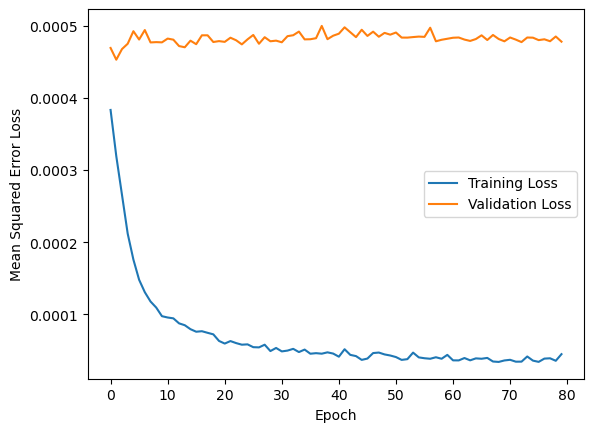

441/441 [==============================] - 0s 630us/step
Root Mean Squared Error (RMSE): 0.020603885186442916
Test Mean Squared Error (MSE): 0.00042452008477612184
R-squared (R2): 0.027282086438214725


In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score


steam_df = pd.read_csv('steam_200k.csv')
new_column_names = ['user_id', 'game', 'behavior', 'playtime', 'zero']
steam_df.columns = new_column_names
steam_df = steam_df.drop('zero', axis=1)

# Filter out rows where 'behavior' is not 'play'
steam_df = steam_df[steam_df['behavior'] == 'play']

steam_df = steam_df.drop('behavior', axis=1)

# Normalize 'playtime'
scaler = MinMaxScaler()
steam_df['playtime'] = scaler.fit_transform(steam_df[['playtime']])

# Convert 'user_id' and 'game' to categorical codes
steam_df['user_id'] = steam_df['user_id'].astype('category').cat.codes
steam_df['game'] = steam_df['game'].astype('category').cat.codes

# Split the dataset
X = steam_df[['user_id', 'game']].values
y = steam_df['playtime'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

n_users = steam_df['user_id'].nunique()
n_games = steam_df['game'].nunique()
n_factors = 100
n_neurons = 128

# Build the model
user_input = Input(shape=(1,), name='user_input')
game_input = Input(shape=(1,), name='game_input')

user_embedding = Embedding(output_dim=n_factors, input_dim=n_users, input_length=1, name='user_embedding')(user_input)
game_embedding = Embedding(output_dim=n_factors, input_dim=n_games, input_length=1, name='game_embedding')(game_input)

user_vector = Flatten(name='flatten_users')(user_embedding)
game_vector = Flatten(name='flatten_games')(game_embedding)

concat = Concatenate()([user_vector, game_vector])

dense = Dense(n_neurons, activation='relu')(concat)
dropout = Dropout(0.5)(dense)
dense_2 = Dense(n_neurons // 2, activation='relu')(dropout)

output = Dense(1)(dense_2)

model = Model(inputs=[user_input, game_input], outputs=output)
model.compile(optimizer=Adam(0.001), loss='mean_squared_error')

# Train the model
history = model.fit([X_train[:, 0], X_train[:, 1]], y_train, epochs=80, batch_size=64, validation_split=0.1)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.show()

# Predict on test data
y_pred = model.predict([X_test[:, 0], X_test[:, 1]])

# Calculate RMSE, Test MSE, and R-squared
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Test Mean Squared Error (MSE): {test_mse}')
print(f'R-squared (R2): {r2}')

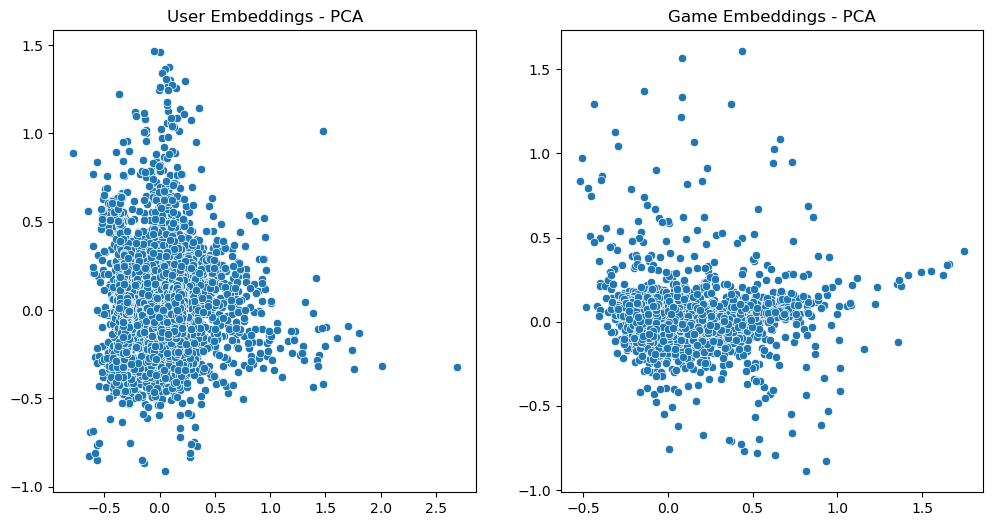

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 11350 samples in 0.000s...
[t-SNE] Computed neighbors for 11350 samples in 0.192s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11350
[t-SNE] Computed conditional probabilities for sample 2000 / 11350
[t-SNE] Computed conditional probabilities for sample 3000 / 11350
[t-SNE] Computed conditional probabilities for sample 4000 / 11350
[t-SNE] Computed conditional probabilities for sample 5000 / 11350
[t-SNE] Computed conditional probabilities for sample 6000 / 11350
[t-SNE] Computed conditional probabilities for sample 7000 / 11350
[t-SNE] Computed conditional probabilities for sample 8000 / 11350
[t-SNE] Computed conditional probabilities for sample 9000 / 11350
[t-SNE] Computed conditional probabilities for sample 10000 / 11350
[t-SNE] Computed conditional probabilities for sample 11000 / 11350
[t-SNE] Computed conditional probabilities for sample 11350 / 11350
[t-SNE] Mean sigma: 0.084464
[t-SNE] KL divergenc

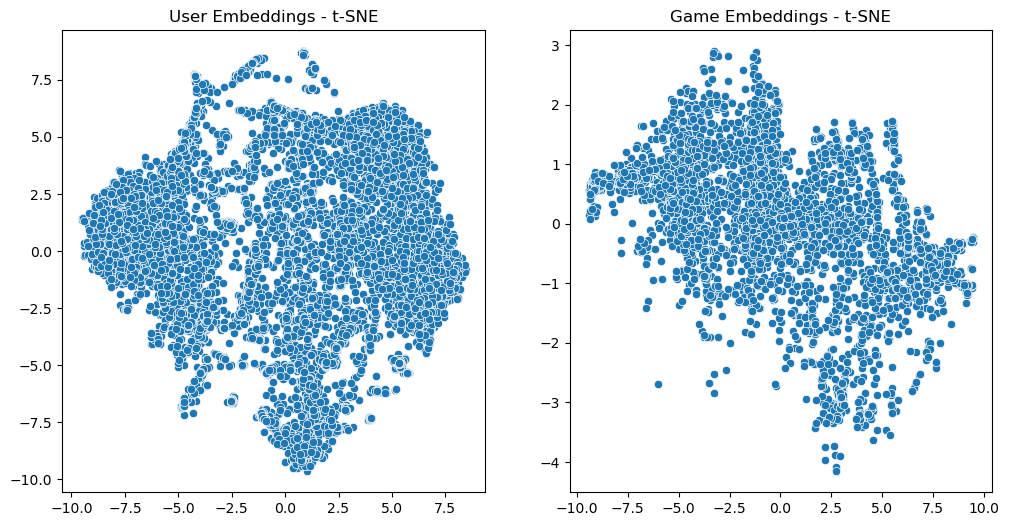

In [12]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# Visualize embeddings using PCA
user_em_weights = model.get_layer('user_embedding').get_weights()[0]
game_em_weights = model.get_layer('game_embedding').get_weights()[0]

pca = PCA(n_components=2)
pca_result_user = pca.fit_transform(user_em_weights)
pca_result_game = pca.fit_transform(game_em_weights)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=pca_result_user[:, 0], y=pca_result_user[:, 1])
plt.title('User Embeddings - PCA')

plt.subplot(1, 2, 2)
sns.scatterplot(x=pca_result_game[:, 0], y=pca_result_game[:, 1])
plt.title('Game Embeddings - PCA')

plt.show()

# Visualize embeddings using t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

tnse_results_user = tsne.fit_transform(user_em_weights)
tnse_results_game = tsne.fit_transform(game_em_weights)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=tnse_results_user[:, 0], y=tnse_results_user[:, 1])
plt.title('User Embeddings - t-SNE')

plt.subplot(1, 2, 2)
sns.scatterplot(x=tnse_results_game[:, 0], y=tnse_results_game[:, 1])
plt.title('Game Embeddings - t-SNE')

plt.show()

In [13]:
# Generate data for all unique games for a user (user_id=1)
game_data = np.array(list(set(steam_df['game'].cat.codes.values)))
user = np.array([1 for _ in range(len(game_data))])

# Make predictions
predictions = model.predict([user, game_data])

# Flatten the predictions array
predictions = np.array([a[0] for a in predictions])

# Get the indices of the top 5 recommended games
recommended_game_ids = (-predictions).argsort()[:5]

# Print recommended game IDs and their predicted playtime
print("Recommended Game IDs:", recommended_game_ids)
print("Predicted Playtime for Recommended Games:", predictions[recommended_game_ids])

113/113 [==============================] - 0s 590us/step
Recommended Game IDs: [1129 1968 1232  922 2146]
Predicted Playtime for Recommended Games: [0.15786058 0.09515826 0.05366415 0.05149601 0.04472588]
